In [2]:
import os, re, sys, argparse, glob
import numpy as np
from network_topology import *
from matplotlib_helper import *
from common_util import *
from math import sqrt
import math
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.ticker import *

In [3]:
def get_exp_name(filename):
    if 'serial' in filename:
        if 'low' in filename:
            return 'Serial low-bw'
        else:
            return 'Serial high-bw'
    elif 'parallel' in filename:
        prefix = 'Parallel '
        if 'hetero' in filename:
            prefix += 'heterogeneous '
        else:
            prefix += 'homogeneous '
        if '2x' in filename:
            prefix += '2x'
        elif '4x' in filename:
            prefix += '4x'
        elif '8x' in filename:
            prefix += '8x'
        else:
            prefix += 'unknown'
        return prefix
    else:
        return filename

In [4]:
def parse_gurobi_result_2_server(filename):
    # example: 'lp-routes.fat-tree.k=10.exp1.all-to-all.ecmp.tcp.any-plane.K=1.1net/run1.single/gurobi.log:Optimal objective 4.01606420e-02'
    regex_line = re.compile(r'(?:.*)?\.k=(\d+).*(all-to-all|permutation).*(\d)net/run(\d+|all).(single|parallel)/gurobi.log:Optimal objective ([\d.e+\-]*)')
    throughput_by_radix_parallelism_run = {}
    for line in open(os.path.join(ROOT_DIR, filename)):
        line = line.strip()
        m = regex_line.match(line)
        if not m:
            raise ValueError('Cannot parse line "%s"' % line)
        radix = int(m.group(1))
        traffic = m.group(2)
        parallelism = int(m.group(3))
        run_id = m.group(4)
        single_or_parallel = m.group(5)
        throughput = float(m.group(6)) # in Gbps
#         print(radix, traffic, parallelism, run_id, single_or_parallel, throughput)
        key = (radix, traffic, parallelism, run_id, single_or_parallel)
        if key not in throughput_by_radix_parallelism_run:
            throughput_by_radix_parallelism_run[key] = []
        throughput_by_radix_parallelism_run[key].append(throughput)
    return throughput_by_radix_parallelism_run

In [5]:
def get_rack_count(radix):
    k = radix
    return int(k * k / 2)

In [6]:
def get_host_count(radix):
    k = radix
    return int(pow(k, 3) / 4)

In [7]:
def get_flow_count(radix, traffic):
    host_count = get_host_count(radix)
    if traffic == 'all-to-all':
        return host_count * (host_count - 1)
    elif traffic == 'permutation':
        return host_count
    else:
        raise ValueError('Unrecognized traffic %s' % traffic)

In [8]:
LABEL_SERIAL_LOW_BW = 'Serial low-bw'
LABEL_PARALLEL = 'Parallel'
LABEL_SERIAL_HIGH_BW = 'Serial high-bw'
LABEL_PARALLEL_HETERO = 'Parallel heterogeneous'
LABEL_PARALLEL_HOMO = 'Parallel homogeneous'

HATCH_PATTERN_INDICES = {
    LABEL_SERIAL_LOW_BW: 0,
    LABEL_PARALLEL: 1,
    LABEL_PARALLEL_HOMO: 1,
    LABEL_PARALLEL_HETERO: 2,
    LABEL_SERIAL_HIGH_BW: 3
}

COLORS = {
    LABEL_SERIAL_LOW_BW: '#1f77b4',
    LABEL_PARALLEL: '#ff7f0e',
    LABEL_PARALLEL_HOMO: '#ff7f0e',
    LABEL_PARALLEL_HETERO: '#2ca02c',
    LABEL_SERIAL_HIGH_BW: '#d62728',
}

{1: {'Serial low-bw': (100.0, 0.07602124910506101)}, 2: {'Parallel heterogeneous': (224.79127623322418, 0.0), 'Serial high-bw': (200.0, 0.15204249821012203)}, 4: {'Parallel heterogeneous': (518.3467757595733, 0.0), 'Serial high-bw': (400.0, 0.30408499642024406)}, 8: {'Parallel heterogeneous': (1174.2411224609175, 0.0), 'Serial high-bw': (800.0, 0.6081699928404881)}}


/tmp/ipykernel_2769394/2889829599.py:163: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  rects = ax.bar(data['x'], data['y'], bar_width, yerr=data['yerr'], label=series, color='white', edgecolor='black', hatch=get_pattern(HATCH_PATTERN_INDICES[series])*2)


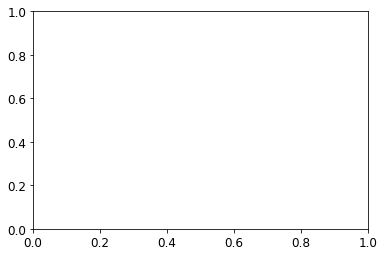

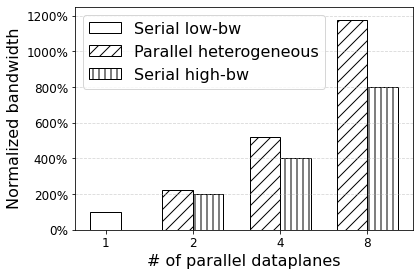

In [12]:
# Figure 7
# 1.network-core.all-to-all

BASE_DIR=os.path.expanduser('../data/1.synthetic/1.bulk')
ROOT_DIR=os.path.join(BASE_DIR, "1.network-core.all-to-all")

# topology = 'fat-tree'
topology = 'jellyfish'
# topology = ''

plot_percentage = True

regex_line = re.compile(r'(?:[\w/-]+/)?(.*)\.run(\d+)\.sol:# Objective value = ([\d.e+\-]*)')
index = 0
throughput_by_exp_name = {}

RADICES = [16]
PARALLELISMS = [1, 2, 4, 8]

color_dict = {}
for parallelism in PARALLELISMS:
    color_dict[parallelism] = get_next_color()

for filename in sorted(os.listdir(ROOT_DIR)):
    if not filename.startswith('result.'):
        continue
    if topology not in filename:
        continue
    # plt.figure()
    fig, ax = plt.subplots()
    # example: 'result.fat-tree.lp-routes.all-to-all.txt'
    regex_filename = re.compile(r'result\.([\w-]+)\.(lp|lp-routes|packet)\.(all-to-all|permutation)\.txt')
    m = regex_filename.match(filename)
    assert m, 'Cannot parse filename %s' % filename
    topology = m.group(1)
    mode = m.group(2)
    traffic = m.group(3)
#     print(topology, mode, traffic)
    data = parse_gurobi_result_2_server(filename)
    data_by_line_series = {}
    LINE_SERIES = []
    if topology == 'fat-tree':
        LINE_SERIES += [ LABEL_SERIAL_LOW_BW, LABEL_PARALLEL, LABEL_SERIAL_HIGH_BW ]
    elif topology == 'jellyfish':
        LINE_SERIES += [
            LABEL_SERIAL_LOW_BW,
#             LABEL_PARALLEL_HOMO,
            LABEL_PARALLEL_HETERO,
            LABEL_SERIAL_HIGH_BW
        ]
    else:
        raise ValueError('Unrecognized topology: %s' % topology)
    for line in LINE_SERIES:
        data_by_line_series[line] = {}
        for parallelism in PARALLELISMS:
            if line == LABEL_SERIAL_LOW_BW and parallelism > 1:
                continue
            if line != LABEL_SERIAL_LOW_BW and parallelism == 1:
                continue
            data_by_line_series[line][parallelism] = {}
            for k in RADICES:
                data_by_line_series[line][parallelism][k] = []
    for k in RADICES:
        for key in sorted(data):
            if key[0] != k:
                continue
            throughput = data[key]
            # key: (8, 'all-to-all', 2, '1', 'parallel')
            parallelism = key[2]
            if topology == 'fat-tree':
                if key[2] == 1: # serial low-bw
                    data_by_line_series[LABEL_SERIAL_LOW_BW][parallelism][k] += throughput
                elif key[4] == 'single': # serial high-bw
                    data_by_line_series[LABEL_SERIAL_HIGH_BW][parallelism][k] += throughput
                elif key[4] == 'parallel': # parallel
                    data_by_line_series[LABEL_PARALLEL][parallelism][k] += throughput
                else:
                    raise ValueError('Unknown category for key %s' % key)
                #end if
            elif topology == 'jellyfish':
                if key[2] == 1: # serial low-bw
                    data_by_line_series[LABEL_SERIAL_LOW_BW][parallelism][k] += throughput
                    for p_ in PARALLELISMS:
                        if p_ == 1:
                            continue
                        # LP-mode serial high-bw is strictly multiples of serial low-bw
                        data_by_line_series[LABEL_SERIAL_HIGH_BW][p_][k] += [t * p_ for t in throughput]
                elif key[4] == 'single': # serial high-bw
                    raise ValueError('Shouldn\'t have this run in this set. Calculate from low-bw instead')
                    data_by_line_series[LABEL_SERIAL_HIGH_BW][parallelism][k] += throughput
                elif key[4] == 'parallel': # parallel
                    if key[3] == 'all': # parallel heterogeneous
                        data_by_line_series[LABEL_PARALLEL_HETERO][parallelism][k] += throughput
                    else: # parallel homogeneous
                        data_by_line_series[LABEL_PARALLEL_HOMO][parallelism][k] += throughput
                    #end if
                else:
                    raise ValueError('Unknown category for key %s' % key)
                #end if
            else:
                raise ValueError('Unknown topology %s' % topology)
            #end if
        #end for key
    #end for k
    
    percentage_by_parallelism_and_series = {}
    for parallelism in PARALLELISMS:
        percentage_by_parallelism_and_series[parallelism] = {}
    for line_series in LINE_SERIES:
        value_dict = data_by_line_series[line_series]
        for parallelism in data_by_line_series[line_series]:
            k=RADICES[0]
            # actual numbers
            throughput_array = np.array(data_by_line_series[line_series][parallelism][k])
            # percentage
            if plot_percentage:
                throughput_baseline = np.average(data_by_line_series[LABEL_SERIAL_LOW_BW][1][k])
#                     throughput_baseline = 10 / (get_flow_count(k, traffic) / get_host_count(k))
                throughput_array = throughput_array / throughput_baseline * 100 # to percentage
            else:
                throughput_array *= get_flow_count(k, traffic) # convert to total bandwidth
            #end
            throughput_avg = np.average(throughput_array)
            throughput_std = np.std(throughput_array)
            percentage_by_parallelism_and_series[parallelism][line_series] = (throughput_avg, throughput_std)
#             label = line_series if line_series == LABEL_SERIAL_LOW_BW else '%s %dx' % (line_series, parallelism)
#             color = color_dict[parallelism]
#             marker = get_marker(int(math.log2(parallelism)))
#             ax = plt.gca()
#             ax.errorbar(values_x, values_y, yerr=values_err, label=label, color=color, linestyle=get_linestyle(linestyle_index), marker=marker)
        #end for parallelism
    #end for line_series
    print(percentage_by_parallelism_and_series)
    # bar plot, grouped by parallelism and each group can have multiple series
    max_group_size = 0
    for parallelism in percentage_by_parallelism_and_series:
        max_group_size = max(0, len(percentage_by_parallelism_and_series[parallelism].keys()))
    bar_width = (1-0.3) / max_group_size
    bar_plot_data_by_series = {}
    for series in LINE_SERIES:
        bar_plot_data_by_series[series] = {
            'x': [],
            'y': [],
            'yerr': [],
        }
    #end
    for parallelism in percentage_by_parallelism_and_series:
        # center of the group
        x_base = math.log2(parallelism)
        percentage_by_series = percentage_by_parallelism_and_series[parallelism]
        num_series_in_group = len(percentage_by_series)
        # offset of 1st bar within group
        x_offset_base = -(num_series_in_group - 1) / 2 * bar_width
        index_in_group = 0
        for series in percentage_by_series:
            (avg, std) = percentage_by_series[series]
            bar_plot_data_by_series[series]['x'].append(x_base + x_offset_base + bar_width * index_in_group)
            bar_plot_data_by_series[series]['y'].append(avg)
            bar_plot_data_by_series[series]['yerr'].append(std)
            index_in_group += 1
    for series in bar_plot_data_by_series:
        data = bar_plot_data_by_series[series]
        rects = ax.bar(data['x'], data['y'], bar_width, yerr=data['yerr'], label=series, color='white', edgecolor='black', hatch=get_pattern(HATCH_PATTERN_INDICES[series])*2)
#         autolabel(ax, rects)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('# of parallel dataplanes', fontsize=16)
    ax.set_ylabel('Normalized bandwidth', fontsize=16)
    ax.set_xticks([int(math.log2(parallelism)) for parallelism in PARALLELISMS])
    ax.set_xticklabels(PARALLELISMS)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, alpha=0.5, linestyle='--')
    ax.yaxis.set_major_formatter(PercentFormatter())
#     ax.grid(which='major', alpha=0.5)
    plt.ylim(0, 1250 if topology == 'jellyfish' else 825)
    ax.legend(loc='upper left', fontsize=16)
    plt.tight_layout()
    if save_figures:
        plt.savefig('lp.%s.%s.%s.png' % (topology, mode, traffic), bbox_inches='tight')

fat-tree lp-routes all-to-all
{1: {'Serial low-bw': (100.0, 0.0)}, 2: {'Parallel': (200.0, 0.0), 'Serial high-bw': (200.0, 0.0)}, 4: {'Parallel': (400.0, 0.0), 'Serial high-bw': (400.0, 0.0)}, 8: {'Parallel': (800.0, 0.0), 'Serial high-bw': (800.0, 0.0)}}
fat-tree lp-routes permutation
{1: {'Serial low-bw': (100.0, 0.7510041624901135)}, 2: {'Parallel': (126.53745806932541, 1.3845826031313195), 'Serial high-bw': (203.3544539694372, 3.365616908675153)}, 4: {'Parallel': (150.5404398061871, 0.853188456374181), 'Serial high-bw': (398.06187103988066, 7.1031706296364465)}, 8: {'Parallel': (166.30637346254193, 0.43465910509469546), 'Serial high-bw': (792.396571002609, 9.381816010467263)}}


/tmp/ipykernel_2769394/2448673850.py:162: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  rects = ax.bar(data['x'], data['y'], bar_width, yerr=data['yerr'], label=series, color='white', edgecolor='black', hatch=get_pattern(HATCH_PATTERN_INDICES[series])*2)
/tmp/ipykernel_2769394/2448673850.py:162: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  rects = ax.bar(data['x'], data['y'], bar_width, yerr=data['yerr'], label=series, color='white', edgecolor='black', hatch=get_pattern(HATCH_PATTERN_INDICES[series])*2)


jellyfish lp-routes all-to-all
{1: {'Serial low-bw': (100.0, 0.0)}, 2: {'Parallel homogeneous': (200.0, 0.0), 'Parallel heterogeneous': (200.0, 0.0), 'Serial high-bw': (200.0, 0.0)}, 4: {'Parallel homogeneous': (400.0, 0.0), 'Parallel heterogeneous': (400.0, 0.0), 'Serial high-bw': (400.0, 0.0)}, 8: {'Parallel homogeneous': (800.0, 0.0), 'Parallel heterogeneous': (800.0, 0.0), 'Serial high-bw': (800.0, 0.0)}}
jellyfish lp-routes permutation
{1: {'Serial low-bw': (100.0, 0.0)}, 2: {'Parallel homogeneous': (199.970703125, 0.04475171577105312), 'Parallel heterogeneous': (199.64765214843752, 0.04473318062389664), 'Serial high-bw': (200.0, 0.0)}, 4: {'Parallel homogeneous': (323.1548177246094, 1.7171229837954676), 'Parallel heterogeneous': (313.612372265625, 2.116348690205574), 'Serial high-bw': (400.0, 0.0)}, 8: {'Parallel homogeneous': (478.6669921875, 5.327524369469144), 'Parallel heterogeneous': (449.638671875, 2.254696500869941), 'Serial high-bw': (800.0, 0.0)}}


/tmp/ipykernel_2769394/2448673850.py:162: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  rects = ax.bar(data['x'], data['y'], bar_width, yerr=data['yerr'], label=series, color='white', edgecolor='black', hatch=get_pattern(HATCH_PATTERN_INDICES[series])*2)
/tmp/ipykernel_2769394/2448673850.py:162: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  rects = ax.bar(data['x'], data['y'], bar_width, yerr=data['yerr'], label=series, color='white', edgecolor='black', hatch=get_pattern(HATCH_PATTERN_INDICES[series])*2)


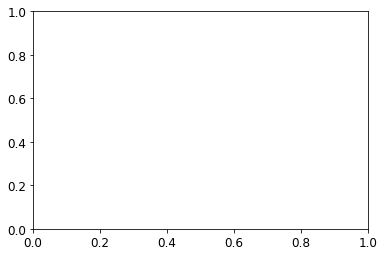

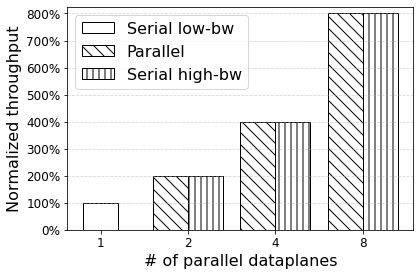

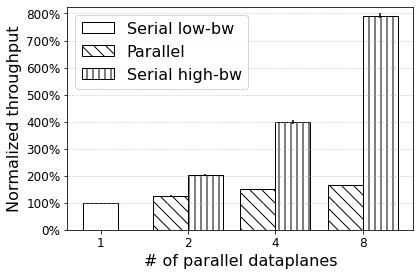

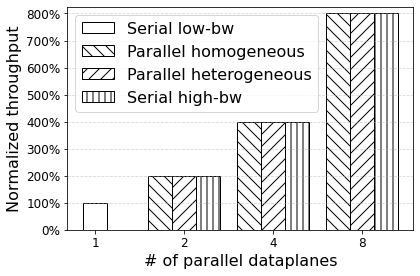

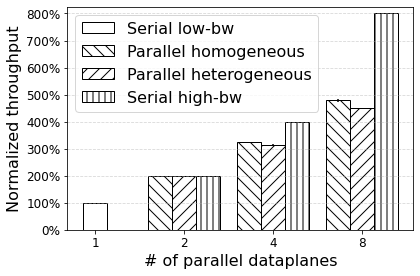

In [13]:
# Figure 6a, 6b, 8a, 8b
# 2.server-to-server

BASE_DIR=os.path.expanduser('../data/1.synthetic/1.bulk')
ROOT_DIR=os.path.join(BASE_DIR, "2.server-to-server")

'''
ax = plt.gca()
positions = [v+1 for v in range(len(xaxis_modes))]
labels = ['ECMP', '2-way KSP', '4-way KSP', '8-way KSP', '16-way KSP', '32-way KSP']
plt.xticks(positions, labels)
ax.yaxis.set_major_formatter(PercentFormatter())
# plt.title('Fat-tree permutation traffic throughput')
# plt.xlabel('Routing algorithm')
plt.ylabel('Percentage of ideal serial low-bw network')
'''

plot_percentage = True

regex_line = re.compile(r'(?:[\w/-]+/)?(.*)\.run(\d+)\.sol:# Objective value = ([\d.e+\-]*)')
index = 0
throughput_by_exp_name = {}

RADICES = [16]
PARALLELISMS = [1, 2, 4, 8]

color_dict = {}
for parallelism in PARALLELISMS:
    color_dict[parallelism] = get_next_color()

for filename in sorted(os.listdir(ROOT_DIR)):
    if not filename.startswith('result.'):
        continue
    fig, ax = plt.subplots()
    # example: 'result.fat-tree.lp-routes.all-to-all.txt'
    regex_filename = re.compile(r'result\.([\w-]+)\.(lp-routes|packet)\.(all-to-all|permutation)\.txt')
    m = regex_filename.match(filename)
    assert m, 'Cannot parse filename %s' % filename
    topology = m.group(1)
    mode = m.group(2)
    traffic = m.group(3)
    print(topology, mode, traffic)
    data = parse_gurobi_result_2_server(filename)
    data_by_line_series = {}
    LINE_SERIES = []
    if topology == 'fat-tree':
        LINE_SERIES += [ LABEL_SERIAL_LOW_BW, LABEL_PARALLEL, LABEL_SERIAL_HIGH_BW ]
    elif topology == 'jellyfish':
        LINE_SERIES += [
            LABEL_SERIAL_LOW_BW,
            LABEL_PARALLEL_HOMO,
            LABEL_PARALLEL_HETERO,
            LABEL_SERIAL_HIGH_BW
        ]
    else:
        raise ValueError('Unrecognized topology: %s' % topology)
    for line in LINE_SERIES:
        data_by_line_series[line] = {}
        for parallelism in PARALLELISMS:
            if line == LABEL_SERIAL_LOW_BW and parallelism > 1:
                continue
            if line != LABEL_SERIAL_LOW_BW and parallelism == 1:
                continue
            data_by_line_series[line][parallelism] = {}
            for k in RADICES:
                data_by_line_series[line][parallelism][k] = []
    for k in RADICES:
        for key in sorted(data):
            if key[0] != k:
                continue
            throughput = data[key]
            # key: (8, 'all-to-all', 2, '1', 'parallel')
            parallelism = key[2]
            if topology == 'fat-tree':
                if key[2] == 1: # serial low-bw
                    data_by_line_series[LABEL_SERIAL_LOW_BW][parallelism][k] += throughput
                elif key[4] == 'single': # serial high-bw
                    data_by_line_series[LABEL_SERIAL_HIGH_BW][parallelism][k] += throughput
                elif key[4] == 'parallel': # parallel
                    data_by_line_series[LABEL_PARALLEL][parallelism][k] += throughput
                else:
                    raise ValueError('Unknown category for key %s' % key)
                #end if
            elif topology == 'jellyfish':
                if key[2] == 1: # serial low-bw
                    data_by_line_series[LABEL_SERIAL_LOW_BW][parallelism][k] += throughput
                elif key[4] == 'single': # serial high-bw
                    data_by_line_series[LABEL_SERIAL_HIGH_BW][parallelism][k] += throughput
                elif key[4] == 'parallel': # parallel
                    if key[3] == 'all': # parallel heterogeneous
#                         continue # TODO: disable heterogeneous for now
                        data_by_line_series[LABEL_PARALLEL_HETERO][parallelism][k] += throughput
                    else: # parallel homogeneous
                        data_by_line_series[LABEL_PARALLEL_HOMO][parallelism][k] += throughput
                    #end if
                else:
                    raise ValueError('Unknown category for key %s' % key)
                #end if
            else:
                raise ValueError('Unknown topology %s' % topology)
            #end if
        #end for key
    #end for k
    percentage_by_parallelism_and_series = {}
    for parallelism in PARALLELISMS:
        percentage_by_parallelism_and_series[parallelism] = {}
    for line_series in LINE_SERIES:
        value_dict = data_by_line_series[line_series]
        for parallelism in data_by_line_series[line_series]:
            k=RADICES[0]
            # actual numbers
            throughput_array = np.array(data_by_line_series[line_series][parallelism][k])
            # percentage
            if plot_percentage:
                throughput_baseline = np.average(data_by_line_series[LABEL_SERIAL_LOW_BW][1][k])
                # new way, total
#                 throughput_baseline = 10 * get_host_count(k)
                throughput_array = throughput_array / throughput_baseline * 100 # to percentage
            else:
                throughput_array *= get_flow_count(k, traffic) # convert to total bandwidth
            #end
            throughput_avg = np.average(throughput_array)
            throughput_std = np.std(throughput_array)
            percentage_by_parallelism_and_series[parallelism][line_series] = (throughput_avg, throughput_std)
#             label = line_series if line_series == LABEL_SERIAL_LOW_BW else '%s %dx' % (line_series, parallelism)
#             color = color_dict[parallelism]
#             marker = get_marker(int(math.log2(parallelism)))
#             ax = plt.gca()
#             ax.errorbar(values_x, values_y, yerr=values_err, label=label, color=color, linestyle=get_linestyle(linestyle_index), marker=marker)
        #end for parallelism
    #end for line_series
    print(percentage_by_parallelism_and_series)
    # bar plot, grouped by parallelism and each group can have multiple series
    max_group_size = 0
    for parallelism in percentage_by_parallelism_and_series:
        max_group_size = max(0, len(percentage_by_parallelism_and_series[parallelism].keys()))
    bar_width = (1-0.2) / max_group_size
    bar_plot_data_by_series = {}
    for series in LINE_SERIES:
        bar_plot_data_by_series[series] = {
            'x': [],
            'y': [],
            'yerr': [],
        }
    #end
    for parallelism in percentage_by_parallelism_and_series:
        # center of the group
        x_base = math.log2(parallelism)
        percentage_by_series = percentage_by_parallelism_and_series[parallelism]
        num_series_in_group = len(percentage_by_series)
        # offset of 1st bar within group
        x_offset_base = -(num_series_in_group - 1) / 2 * bar_width
        index_in_group = 0
        for series in percentage_by_series:
            (avg, std) = percentage_by_series[series]
            bar_plot_data_by_series[series]['x'].append(x_base + x_offset_base + bar_width * index_in_group)
            bar_plot_data_by_series[series]['y'].append(avg)
            bar_plot_data_by_series[series]['yerr'].append(std)
            index_in_group += 1
    for series in bar_plot_data_by_series:
        data = bar_plot_data_by_series[series]
        rects = ax.bar(data['x'], data['y'], bar_width, yerr=data['yerr'], label=series, color='white', edgecolor='black', hatch=get_pattern(HATCH_PATTERN_INDICES[series])*2)
#         autolabel(ax, rects)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('# of parallel dataplanes', fontsize=16)
    ax.set_ylabel('Normalized throughput', fontsize=16)
    ax.set_xticks([int(math.log2(parallelism)) for parallelism in PARALLELISMS])
    ax.set_xticklabels(PARALLELISMS)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, alpha=0.5, linestyle='--')
    ax.yaxis.set_major_formatter(PercentFormatter())
#     ax.grid(which='major', alpha=0.5)
    plt.ylim(0, 825)
    ax.legend(loc='upper left', fontsize=16)
    plt.tight_layout()

    if save_figures:
        plt.savefig('lp-routes.default-routing.%s.%s.%s.png' % (topology, mode, traffic))

In [15]:
def parse_gurobi_result_3_multipath(filename):
    regex_line = re.compile(r'(?:[\w/-]+/)?(.*)\.run(\d+)\.sol:# Objective value = ([\d.e+\-]*)')
    throughput_by_exp_mode = {}
    for line in open(os.path.join(ROOT_DIR, filename)):
        line = line.strip()
        # Example: 'rawdata/serial-low_bw/lp-ideal.run10.sol:# Objective value = 6.8599999999692142e+06'
        m = regex_line.match(line)
        if not m:
            raise ValueError('Cannot parse line "%s"' % line)
        exp_mode = m.group(1)
        run_num = int(m.group(2))
        throughput = float(m.group(3)) / 1e3 # convert from Mbps to Gbps
        if exp_mode not in sorted(throughput_by_exp_mode):
            throughput_by_exp_mode[exp_mode] = []
        throughput_by_exp_mode[exp_mode].append(throughput)
#     for exp_mode in throughput_by_exp_mode:
#         throughput_array = throughput_by_exp_mode[exp_mode]
#         print('\tmode: %s, avg tput: %.f, std tput: %.3f' % (exp_mode, np.average(throughput_array), np.std(throughput_array)))    tput_ideal = throughput_by_exp_mode['lp-ideal']
    return throughput_by_exp_mode

Serial low-bw
Parallel homogeneous 2x
Parallel homogeneous 4x
Parallel homogeneous 8x
Serial low-bw
Parallel homogeneous 2x
Parallel homogeneous 4x
Parallel homogeneous 8x


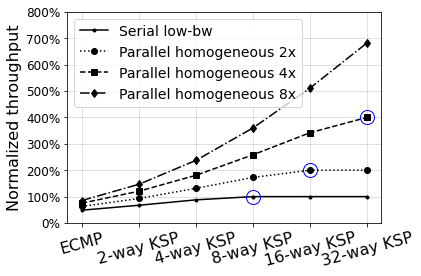

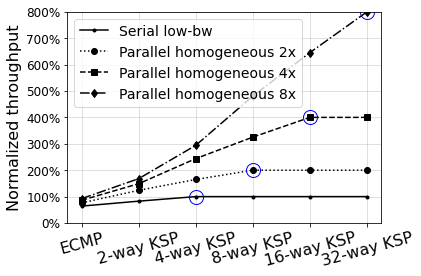

In [18]:
# Figure 6c, 8c
# 3. multipath necessary

BASE_DIR='~/Source/parallel-networks/htsim.data/eval/1.synthetic/1.bulk'

for topology in [ 'fat-tree', 'jellyfish' ]:
    ROOT_DIR=os.path.expanduser(BASE_DIR + "/3.multipath-necessary/%s.h=686.perm" % topology)

    xaxis_modes = [
        'lp-routes.ecmp',
        'lp-routes.ksp.K=2',
        'lp-routes.ksp.K=4',
        'lp-routes.ksp.K=8',
        'lp-routes.ksp.K=16',
        'lp-routes.ksp.K=32',
    ]

    plt.figure()
    ax = plt.gca()
    positions = [v+1 for v in range(len(xaxis_modes))]
    labels = ['ECMP', '2-way KSP', '4-way KSP', '8-way KSP', '16-way KSP', '32-way KSP']
    # labels = ['1-way KSP', '2-way KSP', '4-way KSP', '8-way KSP', '16-way KSP', '32-way KSP']
    plt.xticks(positions, labels, fontsize=16)
    ax.yaxis.set_major_formatter(PercentFormatter())
    # plt.title('%s permutation traffic throughput' % topology)
    # plt.xlabel('Routing algorithm')
    plt.ylabel('Normalized throughput', fontsize=16)

    index = 0
    throughput_by_exp_and_routing = {}
    for filename in sorted(os.listdir(ROOT_DIR)):
        if not filename.startswith('result.'):
            continue
        if 'hetero' in filename:
            continue
        exp_name = get_exp_name(filename)
        throughput_by_exp_and_routing[exp_name] = parse_gurobi_result_3_multipath(filename)

    ideal_throughput = np.average(throughput_by_exp_and_routing['Serial low-bw']['lp-ideal'])
    exp_names = [
        'Serial low-bw',
        'Parallel homogeneous 2x',
        'Parallel homogeneous 4x',
        'Parallel homogeneous 8x',
    #     'Parallel heterogeneous 2x',
    #     'Parallel heterogeneous 4x',
    #     'Parallel heterogeneous 8x',
    ]
    for exp_name in exp_names:
        print(exp_name)
        x_values = positions
        y_values = []
        err_values = []
        for mode in xaxis_modes:
            throughput_array = throughput_by_exp_and_routing[exp_name][mode]
            array_percentage_of_ideal = np.array(throughput_array) / ideal_throughput * 100 # convert to percentage
            avg = np.average(array_percentage_of_ideal)
            std = np.std(array_percentage_of_ideal)
            y_values.append(avg)
            err_values.append(std)
    #     ax.errorbar(x_values, y_values, yerr=err_values, label=exp_name, color='black', linestyle=get_linestyle(index), marker=get_marker(index))
        plt.plot(x_values, y_values, label=exp_name, color='black', linestyle=get_linestyle(index), marker=get_marker(index))
        index += 1

    plt.legend(loc='upper left')
    plt.ylim(0, 800)
    ax.grid(which='major', alpha=0.5)
    reorder_legend(ax, ['Serial low-bw', 'Parallel homogeneous 2x', 'Parallel homogeneous 4x', 'Parallel homogeneous 8x'], fontsize=14, loc='upper left')

    if topology == 'fat-tree':
        highlight_coordinates = [
            (4, 100),
            (5, 200),
            (6, 400),
        ]
    else:
        highlight_coordinates = [
            (3, 100),
            (4, 200),
            (5, 400),
            (6, 800),
        ]

    for coordinate in highlight_coordinates:
        (x, y) = coordinate
        ax.plot(x, y, 'bo',fillstyle='none',markersize=14)

    plt.xticks(rotation = 15)
    plt.tight_layout()
    if save_figures:
        plt.savefig('%s.h=686.perm.serial-vs-parallel.ideal-with-routes.png' % topology)